## Genre Classification Pipeline

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

# Set seed for reproducibility
np.random.seed(100)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# load the dataset
import csv
data = pd.read_csv('/content/lyrics.csv')

## Data Visualization

In [ ]:
# 1. Total Samples
total_samples = data.shape[0]
print(f"Numero totale di campioni nel dataset: {total_samples}")

Numero totale di campioni nel dataset: 362237


In [ ]:
# 2. Unique genre values
unique_genres = data['genre'].unique()
print(f"Generi unici nel dataset: {unique_genres}")

Generi unici nel dataset: ['Pop' 'Hip-Hop' 'Not Available' 'Other' 'Rock' 'Metal' 'Country' 'Jazz'
 'Electronic' 'Folk' 'R&B' 'Indie']


In [ ]:
# 4. First 3 samples
print("\nPrimi 3 campioni del dataset pulito:")
print(data.head(3))


Primi 3 campioni del dataset pulito:
   index          song  year           artist genre  \
0      0     ego-remix  2009  beyonce-knowles   Pop   
1      1  then-tell-me  2009  beyonce-knowles   Pop   
2      2       honesty  2009  beyonce-knowles   Pop   

                                              lyrics  
0  Oh baby, how you doing?\nYou know I'm gonna cu...  
1  playin' everything so easy,\nit's like you see...  
2  If you search\nFor tenderness\nIt isn't hard t...  



Distribuzione dei generi (numero di campioni per genere):
genre
Rock             131377
Pop               49444
Hip-Hop           33965
Not Available     29814
Metal             28408
Other             23683
Country           17286
Jazz              17147
Electronic        16205
R&B                5935
Indie              5732
Folk               3241
Name: count, dtype: int64


<ipython-input-28-5db1dce13426>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_distribution.index, y=genre_distribution.values, palette="viridis")


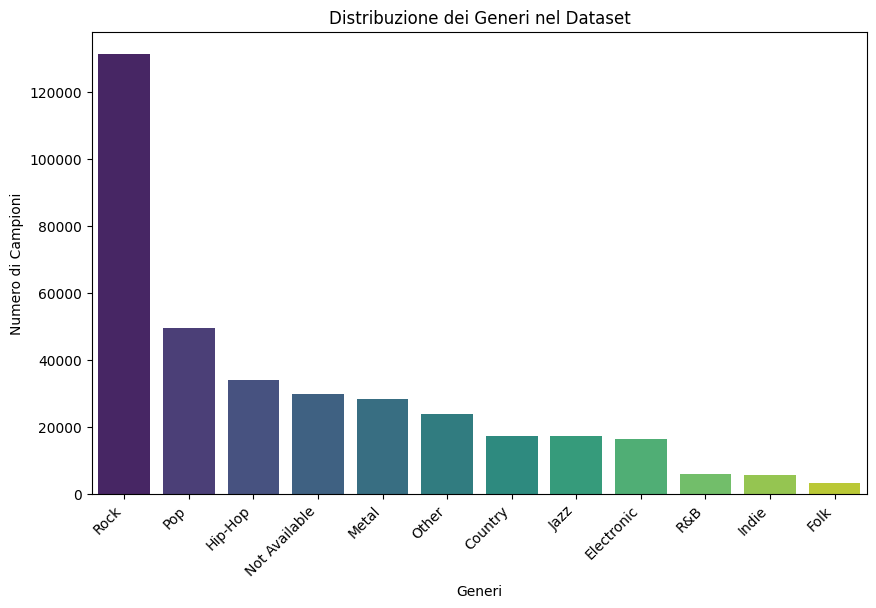

In [ ]:
# 3. Genres Distribution
genre_distribution =  data['genre'].value_counts()
print("\nDistribuzione dei generi (numero di campioni per genere):")
print(genre_distribution)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_distribution.index, y=genre_distribution.values, palette="viridis")
plt.title("Distribuzione dei Generi nel Dataset")
plt.xlabel("Generi")
plt.ylabel("Numero di Campioni")
plt.xticks(rotation=45, ha='right')
plt.show()



## 1.   Cleaning




In [ ]:
# Remove rows with missing genres or lyrics
data = data.dropna(subset=['genre', 'lyrics'])

# Remove entries where genre is 'Not Available'
data = data[data['genre'].str.lower() != 'not available']

# Strip leading/trailing whitespace from lyrics
data['lyrics'] = data['lyrics'].str.strip()

<ipython-input-29-ba65d3c7c8b4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lyrics'] = data['lyrics'].str.strip()


In [ ]:
filtered = data[data['lyrics'].notnull()]
cleaned = filtered.copy()

In [ ]:
# Remove punctuation and song-related identifiers
cleaned['lyrics'] = cleaned['lyrics'].str.replace("[-\?.,\/#!$%\^&\*;:{}=\_~()]", ' ')
cleaned['lyrics'] = cleaned['lyrics'].str.replace("\[(.*?)\]", ' ')
cleaned['lyrics'] = cleaned['lyrics'].str.replace("' | '", ' ')
cleaned['lyrics'] = cleaned['lyrics'].str.replace('x[0-9]+', ' ')

In [ ]:
# Remove songs that are instrumental or with corrupted characters
cleaned = cleaned[cleaned['lyrics'].str.strip().str.lower() != 'instrumental']
cleaned = cleaned[~cleaned['lyrics'].str.contains(r'[^\x00-\x7F]+')]
cleaned = cleaned[cleaned['lyrics'].str.strip() != '']
cleaned = cleaned[cleaned['genre'].str.lower() != 'not available']



Data Visualization I



In [ ]:
# 1. total samples
total_samples = cleaned.shape[0]
print(f"Numero totale di campioni nel dataset: {total_samples}")

Numero totale di campioni nel dataset: 229558


In [ ]:
# 2. Unique genre values
unique_genres = cleaned['genre'].unique()
print(f"Generi unici nel dataset: {unique_genres}")


Generi unici nel dataset: ['Pop' 'Hip-Hop' 'Rock' 'Metal' 'Other' 'Country' 'Jazz' 'Electronic'
 'Folk' 'R&B' 'Indie']



Distribuzione dei generi (numero di campioni per genere):
genre
Rock          105218
Pop            36486
Hip-Hop        23235
Metal          23198
Country        14193
Jazz            7542
Electronic      7349
Other           3992
R&B             3358
Indie           2980
Folk            2007
Name: count, dtype: int64


<ipython-input-35-f696d427af2d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_distribution.index, y=genre_distribution.values, palette="viridis")


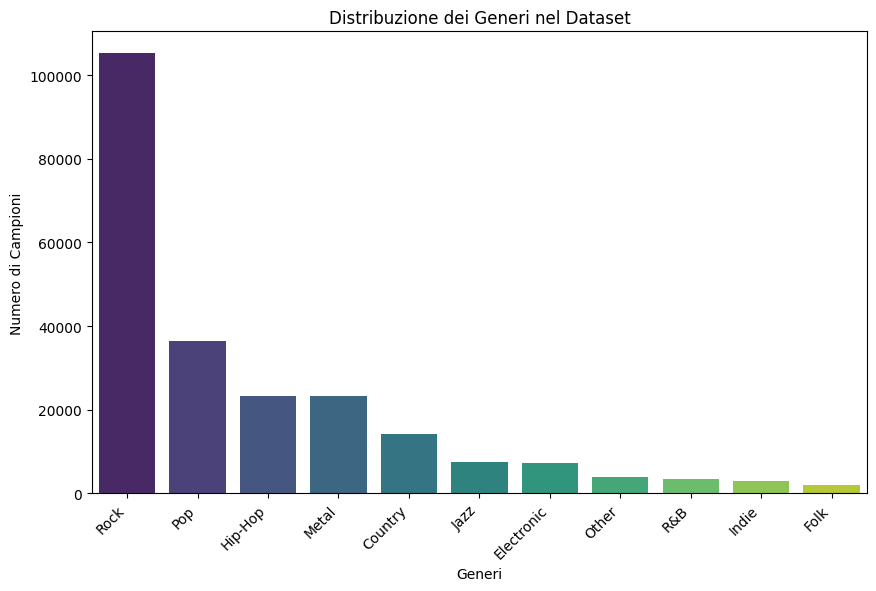

In [ ]:
# 3. Genres Distribution
genre_distribution = cleaned['genre'].value_counts()
print("\nDistribuzione dei generi (numero di campioni per genere):")
print(genre_distribution)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_distribution.index, y=genre_distribution.values, palette="viridis")
plt.title("Distribuzione dei Generi nel Dataset")
plt.xlabel("Generi")
plt.ylabel("Numero di Campioni")
plt.xticks(rotation=45, ha='right')
plt.show()

Filtering

In [ ]:
# Filter genres
cleaned = cleaned.loc[(cleaned['genre'] == 'Pop') |
                      (cleaned['genre'] == 'Rock') |
                      (cleaned['genre'] == 'Hip-Hop')|
                      (cleaned['genre'] == 'Metal')
                      ]

Data Visualization II


Distribuzione dei generi (numero di campioni per genere):
genre
Rock       105218
Pop         36486
Hip-Hop     23235
Metal       23198
Name: count, dtype: int64


<ipython-input-39-f696d427af2d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_distribution.index, y=genre_distribution.values, palette="viridis")


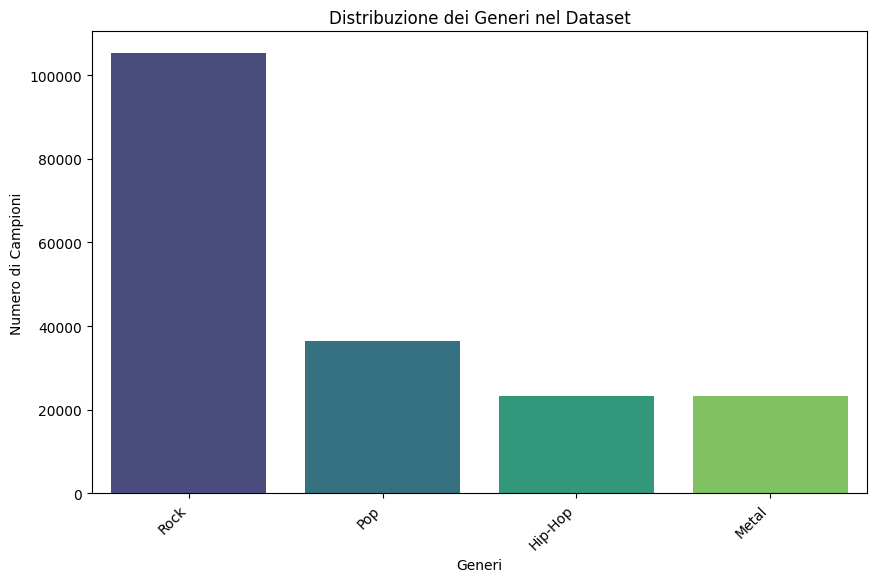

In [ ]:
# 3. Genres Distribution
genre_distribution = cleaned['genre'].value_counts()
print("\nDistribuzione dei generi (numero di campioni per genere):")
print(genre_distribution)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_distribution.index, y=genre_distribution.values, palette="viridis")
plt.title("Distribuzione dei Generi nel Dataset")
plt.xlabel("Generi")
plt.ylabel("Numero di Campioni")
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# 4. First 3 samples
print("\nPrimi 3 campioni del dataset pulito:")
print(cleaned.head(3))


Primi 3 campioni del dataset pulito:
   index          song  year           artist genre  \
0      0     ego-remix  2009  beyonce-knowles   Pop   
1      1  then-tell-me  2009  beyonce-knowles   Pop   
2      2       honesty  2009  beyonce-knowles   Pop   

                                              lyrics  
0  Oh baby, how you doing?\nYou know I'm gonna cu...  
1  playin' everything so easy,\nit's like you see...  
2  If you search\nFor tenderness\nIt isn't hard t...  


In [ ]:
# Reset index after cleaning
cleaned.reset_index(inplace=True)

Dataset Undersampling

In [ ]:
# Perform undersampling
balanced_samples = []
genres = cleaned['genre'].unique()
for genre in genres:
    genre_subset = cleaned[cleaned['genre'] == genre]
    if len(genre_subset) >= 23198:
            balanced_samples.append(genre_subset.sample(n=23198, random_state=42))
    else:
            print(f"Not enough samples for genre '{genre}', only {len(genre_subset)} available.")
            balanced_samples.append(genre_subset.sample(n=len(genre_subset), random_state=42))

    balanced_dataset = pd.concat(balanced_samples, ignore_index=True)

Data Visualization III

In [ ]:
# 1. Total Samples
total_samples = balanced_dataset.shape[0]
print(f"Numero totale di campioni nel dataset: {total_samples}")

Numero totale di campioni nel dataset: 92792


In [ ]:
# 2. Unique genre values
unique_genres = balanced_dataset['genre'].unique()
print(f"Generi unici nel dataset: {unique_genres}")

Generi unici nel dataset: ['Pop' 'Hip-Hop' 'Rock' 'Metal']



Distribuzione dei generi (numero di campioni per genere):
genre
Pop        23198
Hip-Hop    23198
Rock       23198
Metal      23198
Name: count, dtype: int64


<ipython-input-45-b961f8cb251e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_distribution.index, y=genre_distribution.values, palette="viridis")


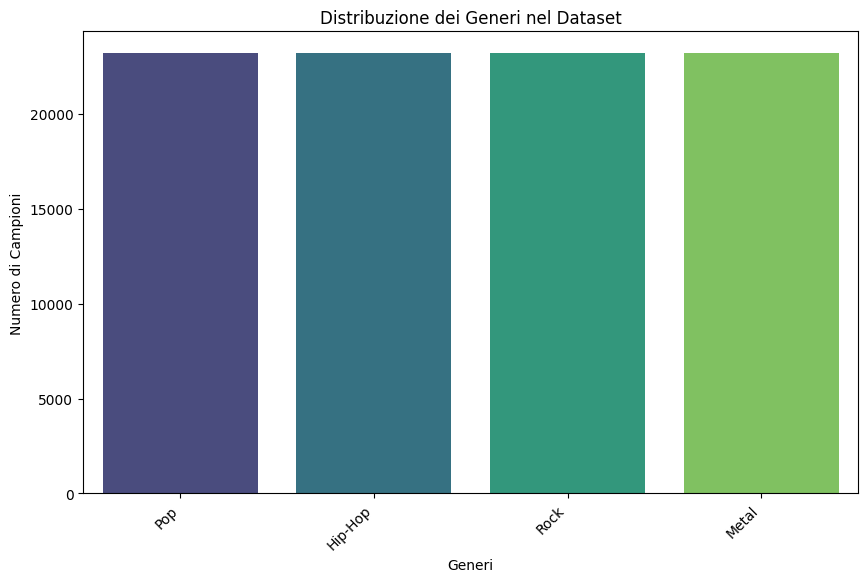

In [ ]:
# 3. Genres distribution
genre_distribution = balanced_dataset['genre'].value_counts()
print("\nDistribuzione dei generi (numero di campioni per genere):")
print(genre_distribution)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_distribution.index, y=genre_distribution.values, palette="viridis")
plt.title("Distribuzione dei Generi nel Dataset")
plt.xlabel("Generi")
plt.ylabel("Numero di Campioni")
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# 4. First 3 samples
print("\nPrimi 3 campioni del dataset pulito:")
print(balanced_dataset.head(3))


Primi 3 campioni del dataset pulito:
   level_0   index           song  year         artist genre  \
0   119739  119739  life-got-cold  2006    girls-aloud   Pop   
1   304543  304543     new-friend  2008  the-concretes   Pop   
2   205316  205316    gettin-high  1975  gino-vannelli   Pop   

                                              lyrics  
0  Oh yeah\nWe text as we eat\nAs we listen to th...  
1  I called you, she answered.\nGot strangled on ...  
2  I don't care much for smokin' weed\nYou know I...  


## Preprocessing

In [ ]:
# Remove stop words
stop = stopwords.words('english')
balanced_dataset['lyrics'] = balanced_dataset['lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

In [ ]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

balanced_dataset['lyrics'] = balanced_dataset['lyrics'].apply(lemmatize_text)

In [ ]:
# Encode genres
Y = balanced_dataset['genre']
Y = LabelEncoder().fit_transform(Y)
balanced_dataset['Y'] = Y.tolist()

In [ ]:
# Split the dataset into training and testing balancing classes with stratify
X_train, X_test, y_train, y_test = train_test_split(
    balanced_dataset['lyrics'],
    balanced_dataset['Y'],
    test_size=0.20,
    random_state=42,
    stratify=balanced_dataset['Y']
)

Data Visualization IV

In [ ]:
# Visualizza la distribuzione dei generi nel training set
print("Distribuzione dei generi nel training set:")
print(y_train.value_counts(normalize=True))

# Visualizza la distribuzione dei generi nel test set
print("\nDistribuzione dei generi nel test set:")
print(y_test.value_counts(normalize=True))

Distribuzione dei generi nel training set:
Y
1    0.250010
0    0.249997
2    0.249997
3    0.249997
Name: proportion, dtype: float64

Distribuzione dei generi nel test set:
Y
3    0.250013
0    0.250013
2    0.250013
1    0.249960
Name: proportion, dtype: float64


In [ ]:
# Hugging Face BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Tokenization and Dataset preparation
class LyricsDataset(Dataset):
    def __init__(self, lyrics, labels, tokenizer, max_len=128):
        self.lyrics = lyrics
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, item):
        text = self.lyrics[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = LyricsDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = LyricsDataset(X_test.tolist(), y_test.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


## Modeling

In [ ]:
# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

Training

In [ ]:
# early stopping parameters
patience = 2
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop with loss tracking
epochs = 5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    print(f'Epoch {epoch + 1} - Training Loss: {epoch_train_loss:.4f}')

    # Evaluation loop with loss tracking for validation set
    model.eval()
    epoch_val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            epoch_val_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs.logits, dim=1)

            # Store true labels and predictions
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_val_loss /= len(test_loader)
    val_losses.append(epoch_val_loss)
    print(f'Epoch {epoch + 1} - Validation Loss: {epoch_val_loss:.4f}')

    # Early stopping logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss  # Update best validation loss
        epochs_without_improvement = 0  # Reset the counter if we find an improvement
    else:
        epochs_without_improvement += 1  # Increment the counter if no improvement

    # If no improvement for 'patience' epochs, stop early
    if epochs_without_improvement >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
        epochs_completed = epoch + 1  # Save the number of epochs completed before stopping
        break



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1 - Training Loss: 0.7840
Epoch 1 - Validation Loss: 0.7589
Epoch 2 - Training Loss: 0.6309
Epoch 2 - Validation Loss: 0.7203
Epoch 3 - Training Loss: 0.4734
Epoch 3 - Validation Loss: 0.7755
Epoch 4 - Training Loss: 0.3114
Epoch 4 - Validation Loss: 0.8813
Early stopping triggered after 4 epochs without improvement.


## Performance Evaluation

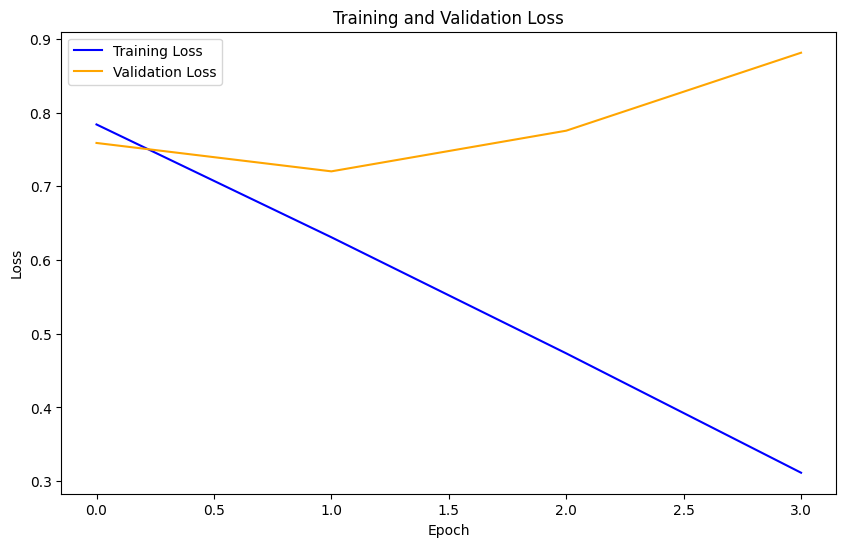

In [ ]:
# If early stopping doesn't trigger, we just complete all epochs
if epochs_without_improvement < patience:
    epochs_completed = epochs

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(epochs_completed), train_losses[:epochs_completed], label='Training Loss', color='blue')
plt.plot(range(epochs_completed), val_losses[:epochs_completed], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Confusion Matrix:
[[3909   75  378  278]
 [ 127 3401  221  890]
 [ 304  154 2807 1375]
 [ 156  443 1035 3006]]


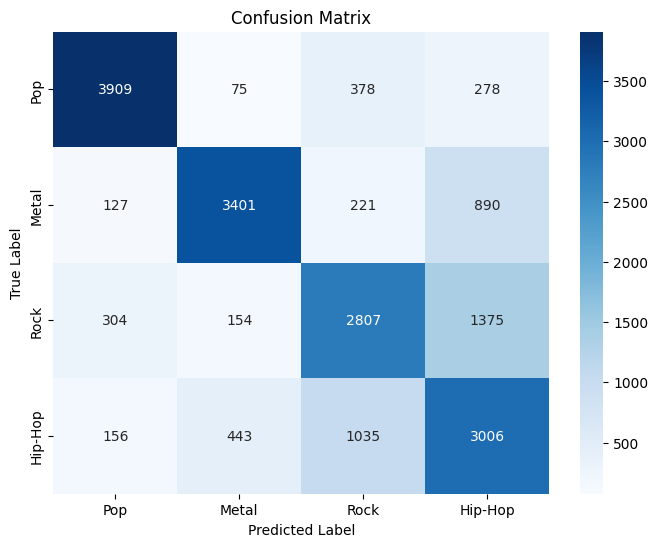

Classification Report:
              precision    recall  f1-score   support

         Pop       0.87      0.84      0.86      4640
       Metal       0.84      0.73      0.78      4639
        Rock       0.63      0.60      0.62      4640
     Hip-Hop       0.54      0.65      0.59      4640

    accuracy                           0.71     18559
   macro avg       0.72      0.71      0.71     18559
weighted avg       0.72      0.71      0.71     18559

Precision: 0.7196
Recall: 0.7071
F1-Score: 0.7112


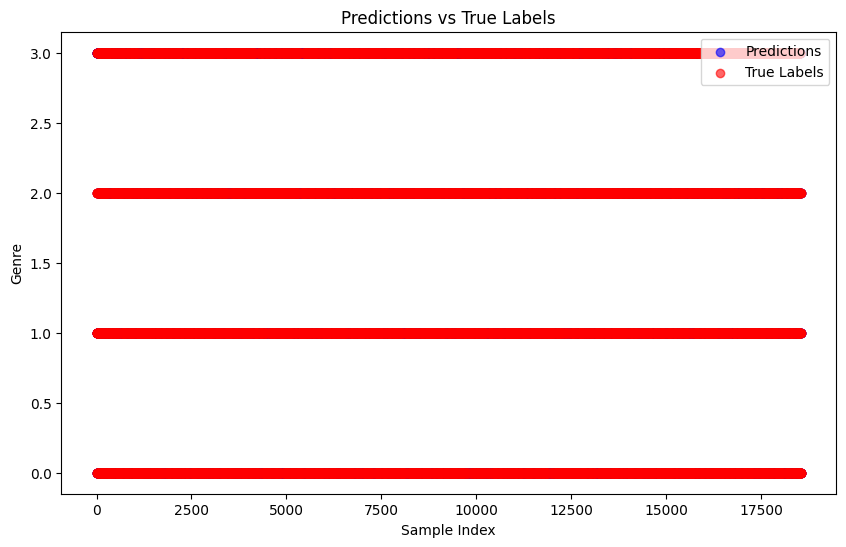

In [ ]:
# After the loop, compute the confusion matrix and other metrics
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Pop", "Metal", "Rock", "Hip-Hop"],
            yticklabels=["Pop", "Metal", "Rock", "Hip-Hop"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(all_labels, all_preds, target_names=["Pop", "Metal", "Rock", "Hip-Hop"])
print("Classification Report:")
print(class_report)

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Plot predictions vs true labels
plt.figure(figsize=(10, 6))
plt.scatter(range(len(all_preds)), all_preds, color='blue', label='Predictions', alpha=0.6)
plt.scatter(range(len(all_labels)), all_labels, color='red', label='True Labels', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Genre')
plt.title('Predictions vs True Labels')
plt.legend(loc='upper right')
plt.show()

